# SAM 3-channel version: DWI, ADC and b0

In [1]:
#channels = "1C=DWI"
channels = "3C=DWI_ADC_b0"
#channels = "3C=DWI_ADC_DifDif"

In [2]:
# Loads all methods and data for testing on JAS
from methods_for_testing_SAM import *

/home/rosengaard/miniforge3/envs/medsam3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


General Sam model 3C=DWI_ADC_b0 version
Volume: 1 of 8


  0%|          | 0/10 [00:00<?, ?it/s]/home/rosengaard/miniforge3/envs/medsam3.9/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 10/10 [01:41<00:00, 10.13s/it]

Dice for slice: 0.875


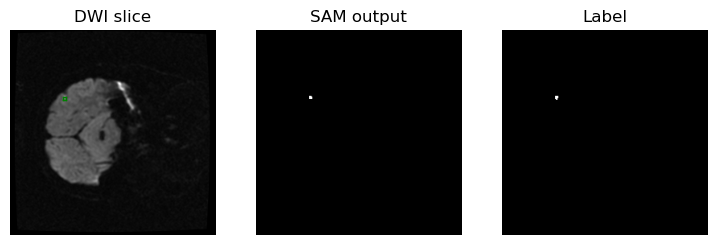

Dice for slice: 0.328


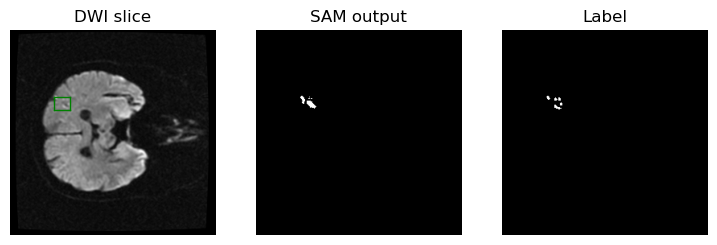

Dice for slice: 0.902


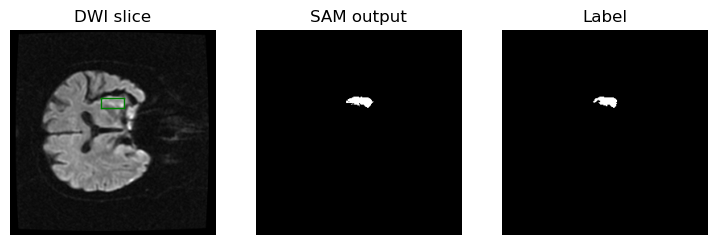

Dice for slice: 0.886


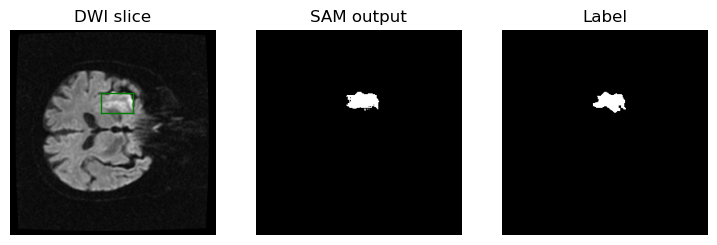

Dice for slice: 0.002


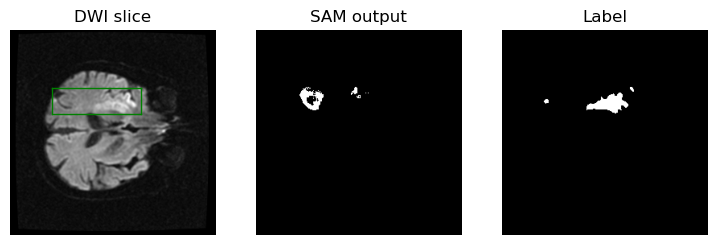

Dice for slice: 0.672


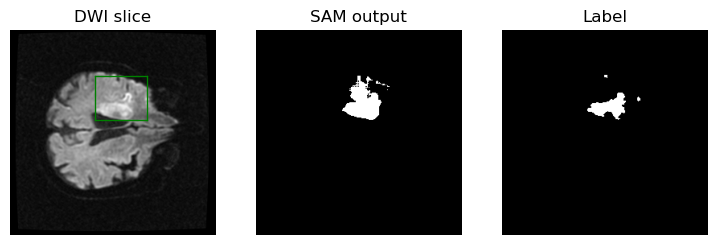

Dice for slice: 0.496


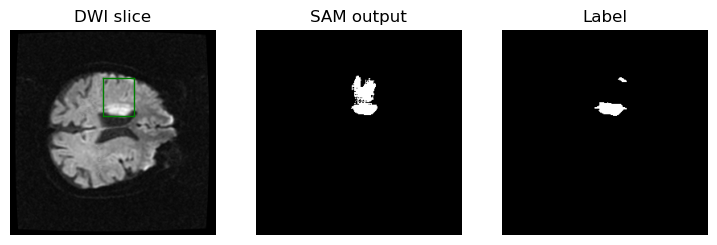

Dice for slice: 0.151


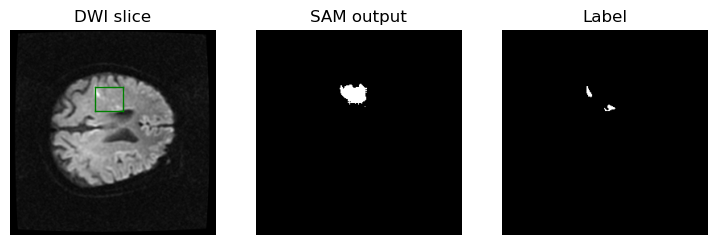

Dice for slice: 0.206


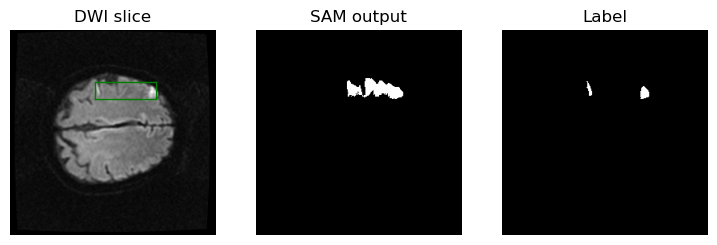

Dice for slice: 0.553


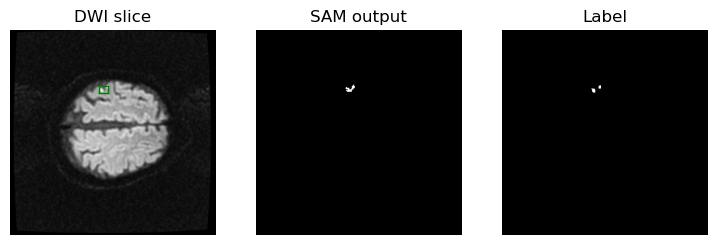

Mean dice for subject: 0.507
_____________________________
Volume: 2 of 8


100%|██████████| 1/1 [00:09<00:00,  9.88s/it]

Dice for slice: 0.929


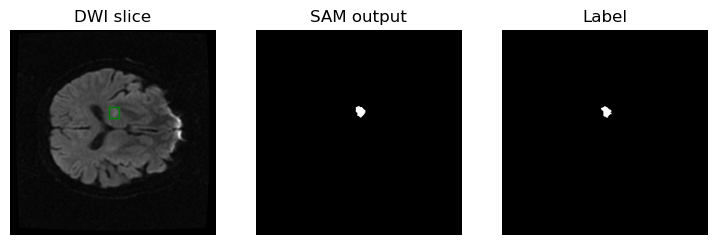

Mean dice for subject: 0.929
_____________________________
Volume: 3 of 8


100%|██████████| 10/10 [01:51<00:00, 11.10s/it]

Dice for slice: 0.671


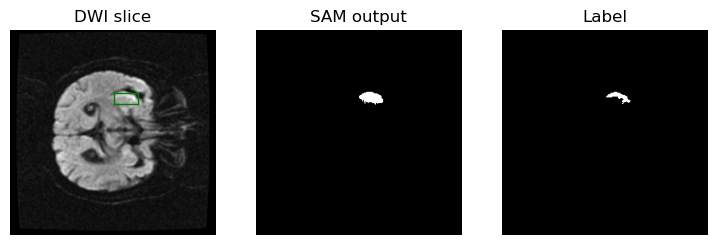

Dice for slice: 0.517


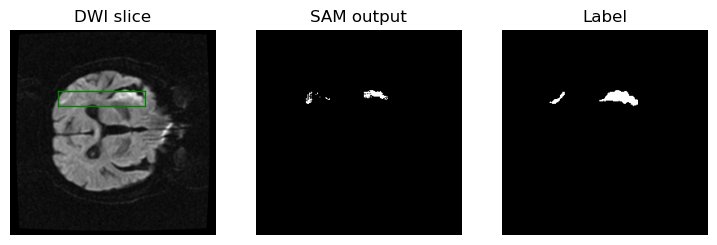

Dice for slice: 0.707


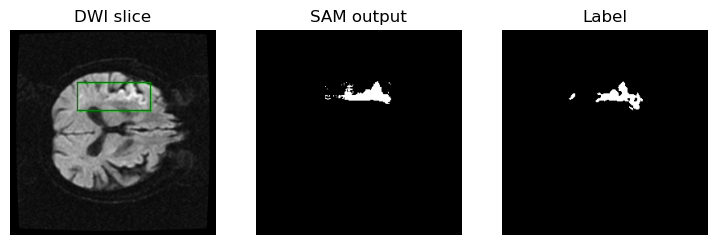

Dice for slice: 0.748


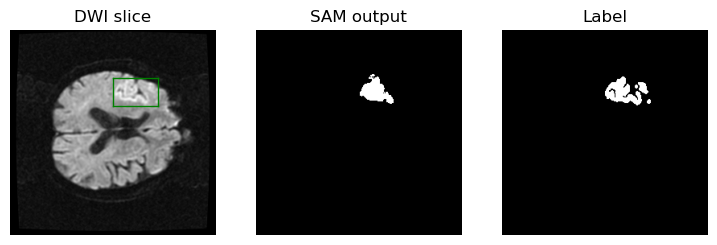

Dice for slice: 0.558


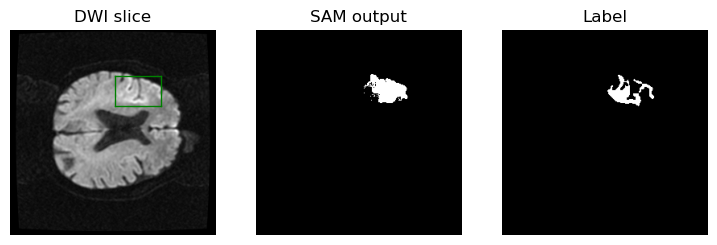

Dice for slice: 0.089


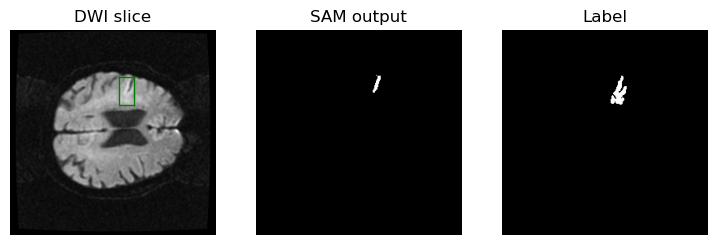

Dice for slice: 0.138


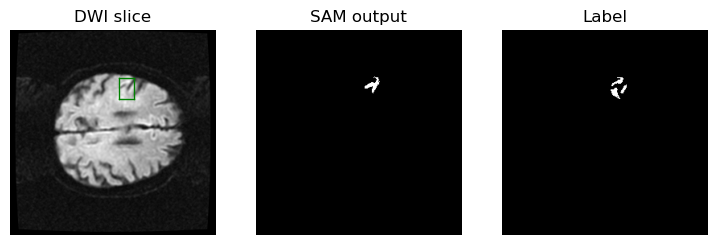

Dice for slice: 0.572


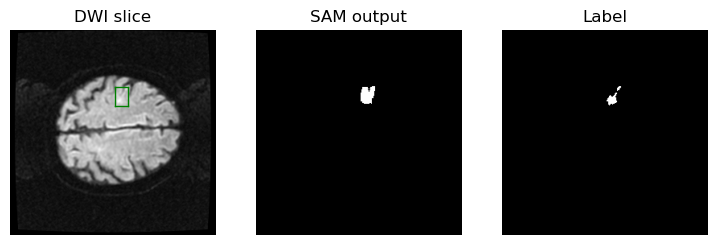

Dice for slice: 0.043


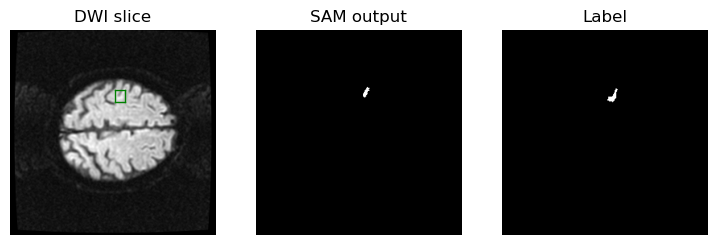

Dice for slice: 0.649


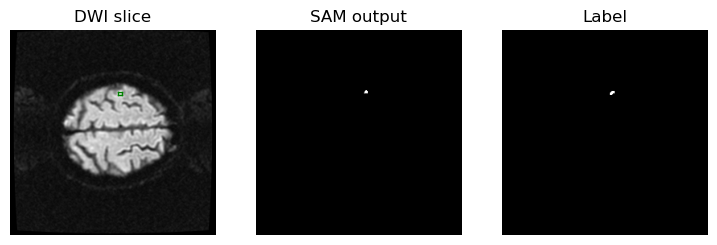

Mean dice for subject: 0.469
_____________________________
Volume: 4 of 8


100%|██████████| 10/10 [01:48<00:00, 10.83s/it]

Dice for slice: 0.887


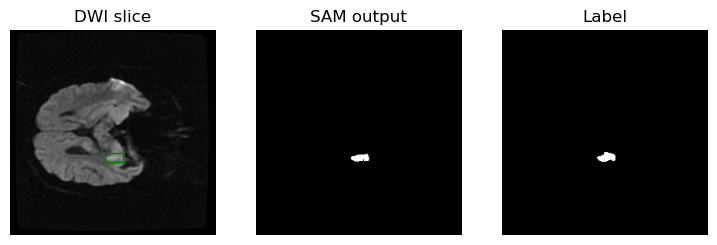

Dice for slice: 0.773


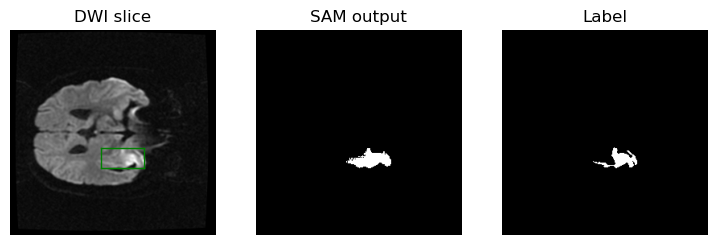

Dice for slice: 0.792


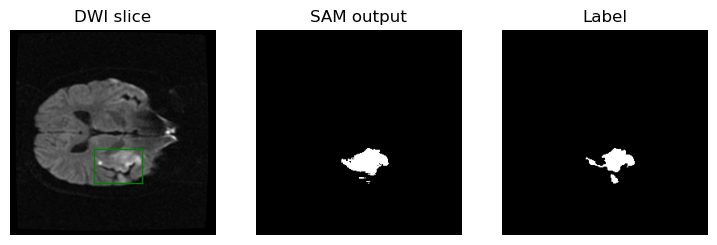

Dice for slice: 0.864


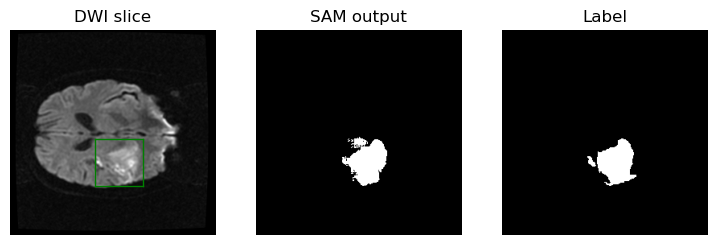

Dice for slice: 0.947


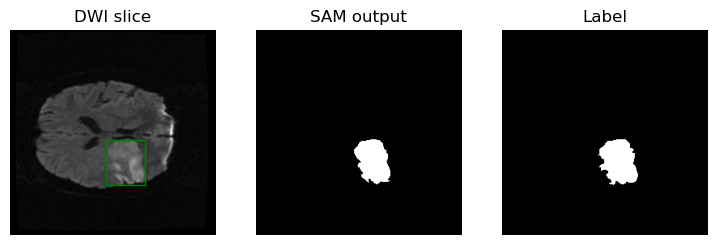

Dice for slice: 0.849


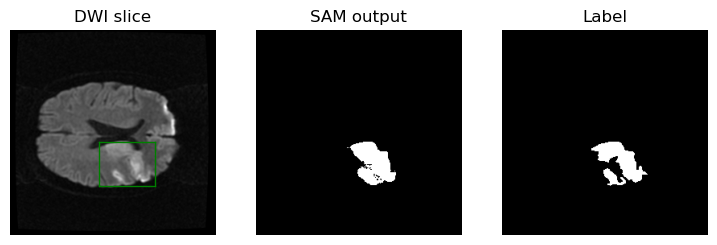

Dice for slice: 0.698


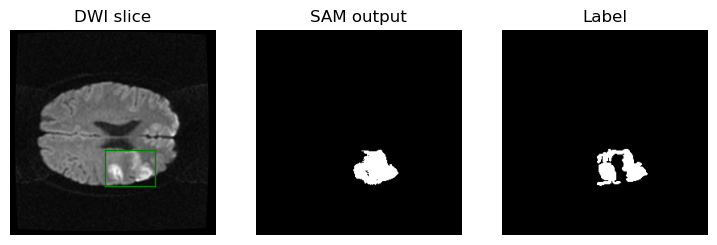

Dice for slice: 0.405


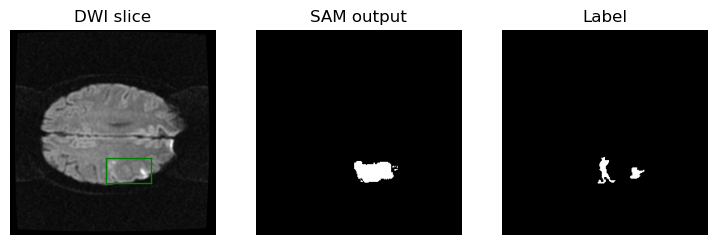

Dice for slice: 0.695


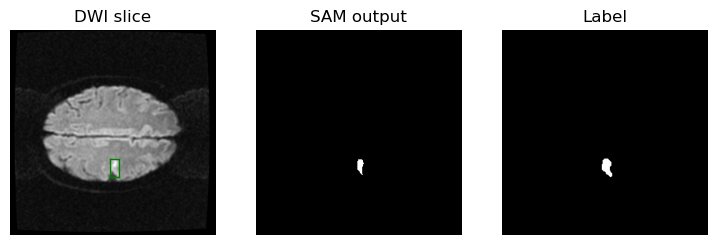

Dice for slice: 0.906


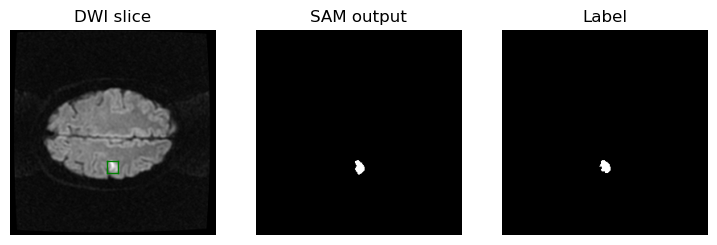

Mean dice for subject: 0.782
_____________________________
Volume: 5 of 8


100%|██████████| 4/4 [00:40<00:00, 10.18s/it]

Dice for slice: 0.867


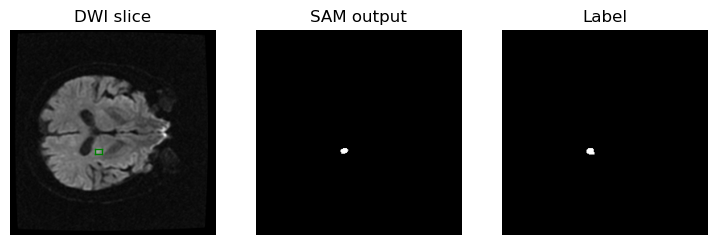

Dice for slice: 0.929


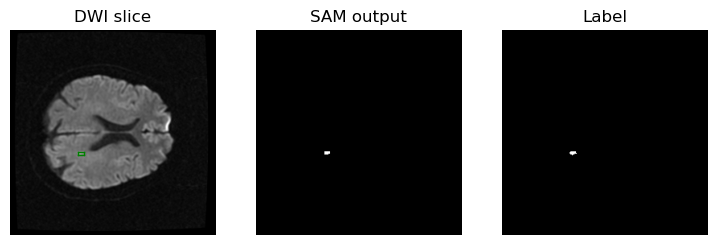

Dice for slice: 0.857


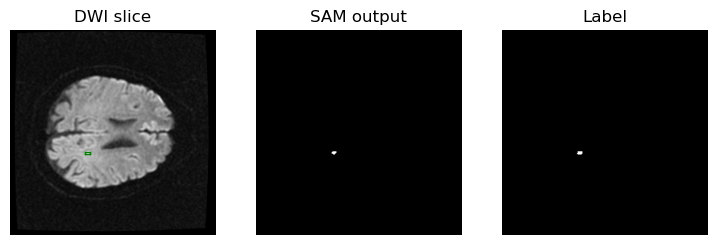

Dice for slice: 0.894


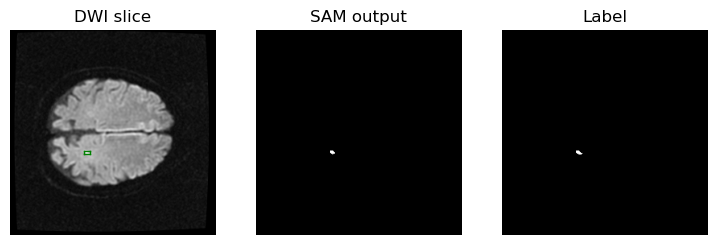

Mean dice for subject: 0.886
_____________________________
Volume: 6 of 8


100%|██████████| 7/7 [01:03<00:00,  9.03s/it]

Dice for slice: 0.749


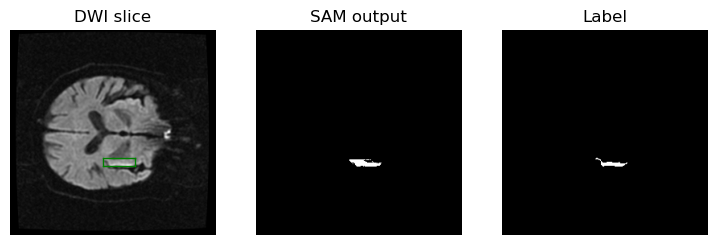

Dice for slice: 0.494


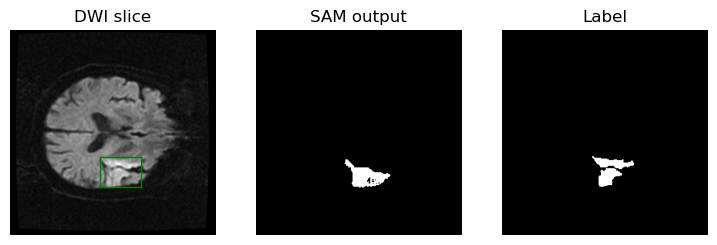

Dice for slice: 0.819


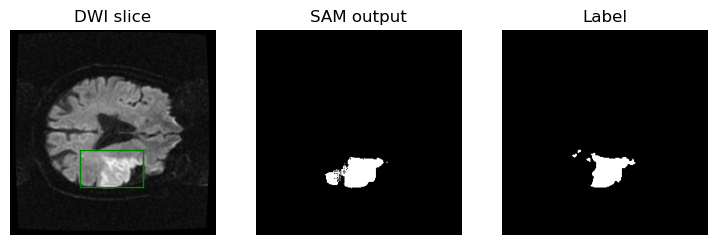

Dice for slice: 0.775


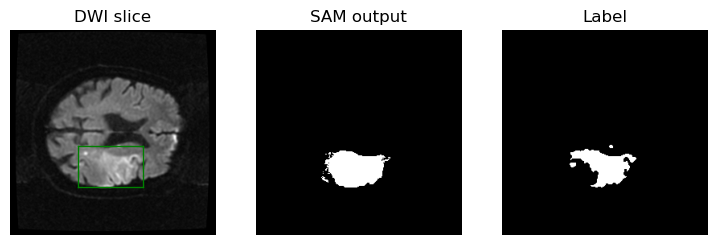

Dice for slice: 0.732


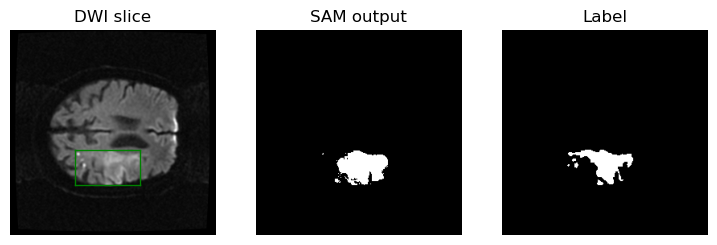

Dice for slice: 0.432


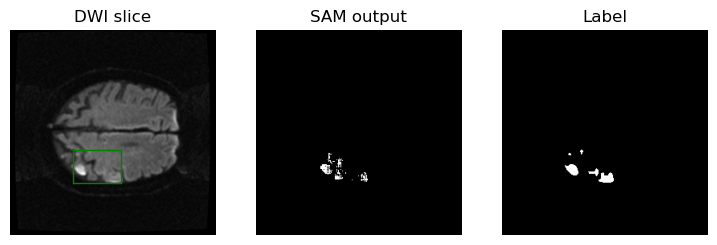

Dice for slice: 0.064


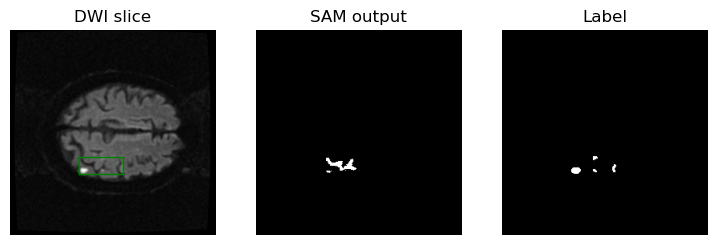

Mean dice for subject: 0.581
_____________________________
Volume: 7 of 8


100%|██████████| 6/6 [01:04<00:00, 10.69s/it]

Dice for slice: 0.857


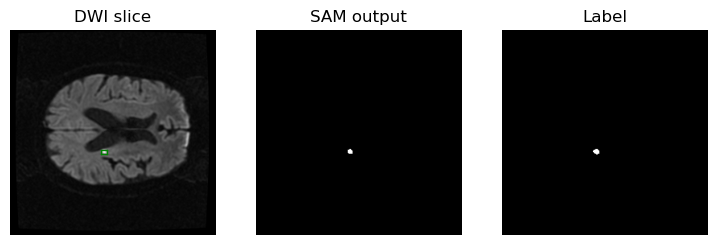

Dice for slice: 0.97


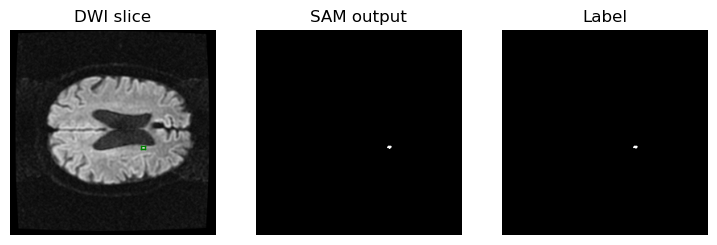

Dice for slice: 0.9


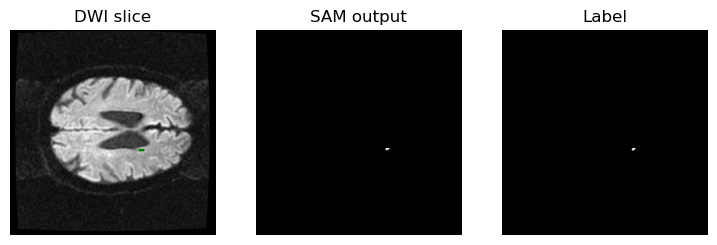

Dice for slice: 0.738


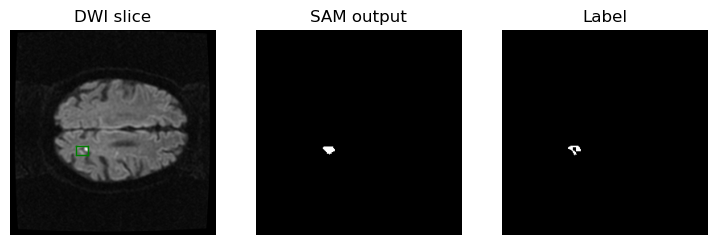

Dice for slice: 0.063


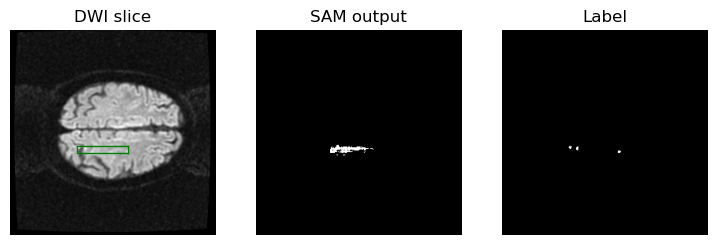

Dice for slice: 0.761


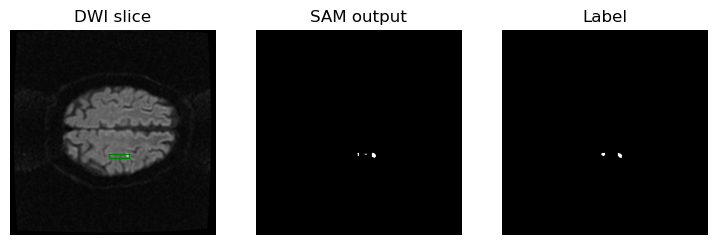

Mean dice for subject: 0.715
_____________________________
Volume: 8 of 8


100%|██████████| 10/10 [01:48<00:00, 10.86s/it]

Dice for slice: 0.915


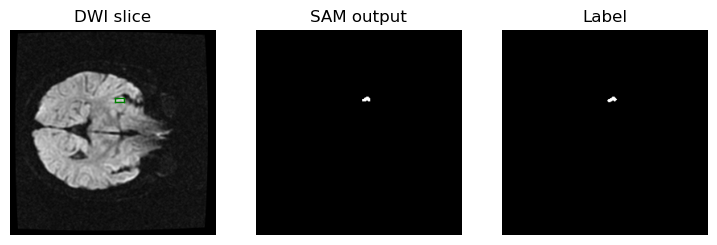

Dice for slice: 0.864


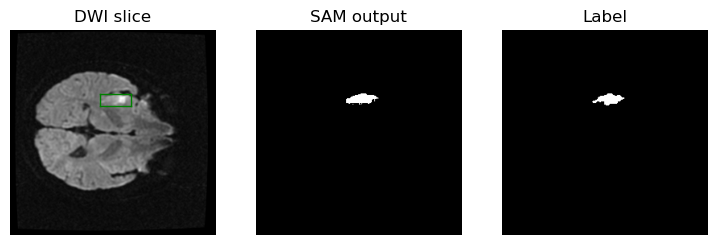

Dice for slice: 0.162


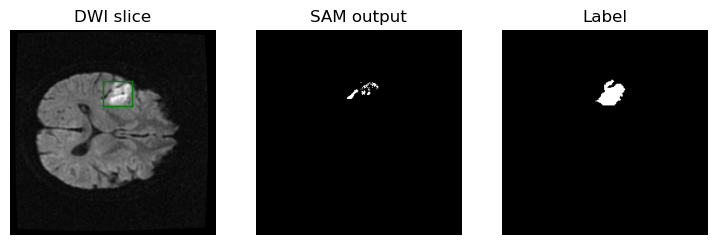

Dice for slice: 0.941


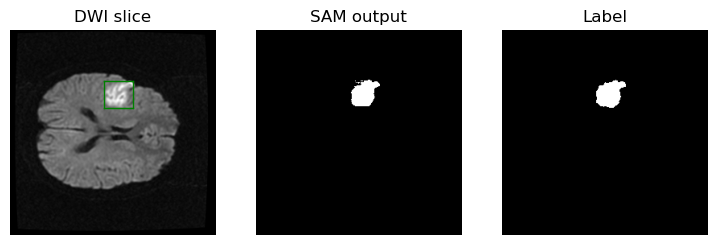

Dice for slice: 0.853


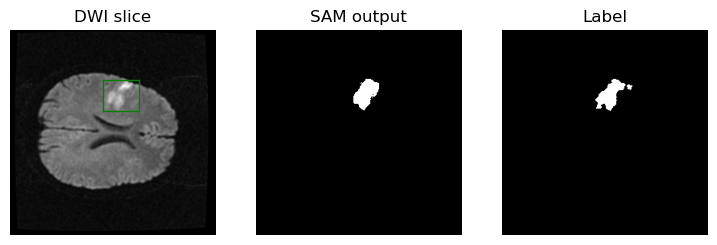

Dice for slice: 0.545


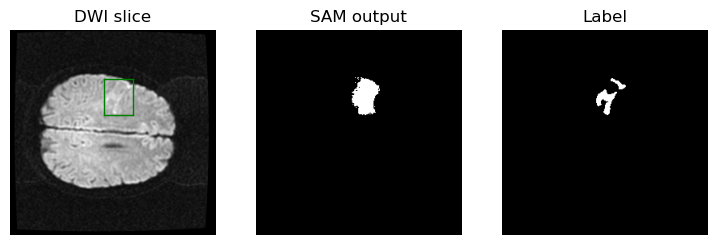

Dice for slice: 0.763


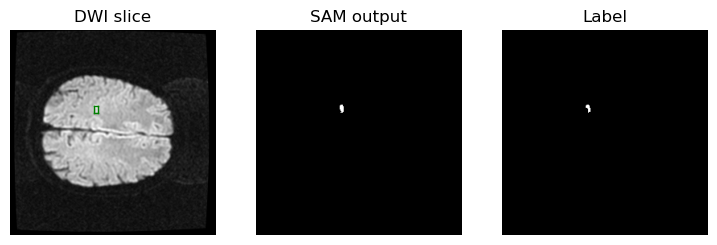

Dice for slice: 0.714


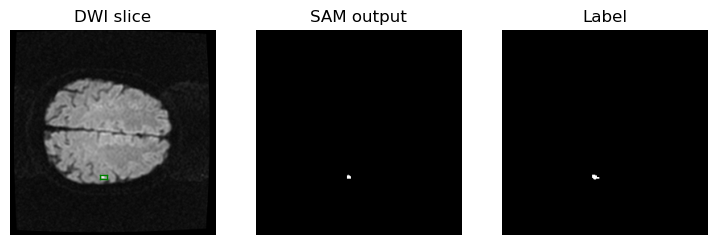

Dice for slice: 0.87


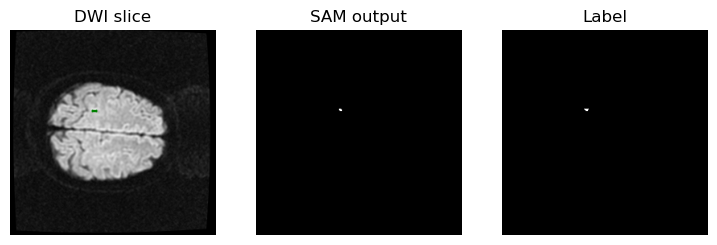

Dice for slice: 0.769


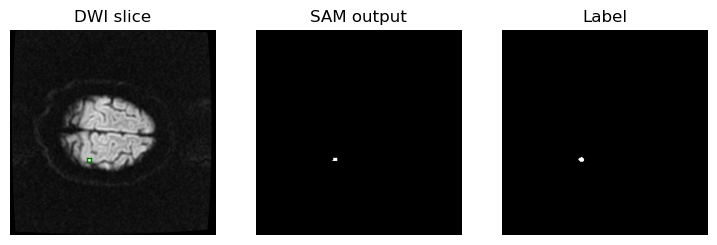

Mean dice for subject: 0.74
_____________________________
______________________________________________
Mean dice for each subject: [0.5069784810307822, 0.9292035398230089, 0.4691960834363567, 0.7816113806755913, 0.886499493414387, 0.5805223384107672, 0.7147919005416934, 0.7396667336627663]

Mean dice for all subjects: 0.7010587438744191


In [3]:
#Test loop
print('General Sam model',channels,'version')
batchSize = 1
type = 'test'
Avg_Dice_subjects = []
Dice_for_subjects = []
for i in range(0,len(data)):
      print(f'Volume: {i+1} of {len(data)}')
      outputs = []
      
      # Get paths to scans and masks for each subject in the datasplit
      DWI_path, ADC_path, b0_path, label_path = data[i]

      # Load data for DAGMNET:
      dataset = getVolume(DWI_path, ADC_path, b0_path, label_path, channels)

      # Get the bounding_box to prompt SAM:
      label_vol = nib.load(label_path).get_fdata()
      prompt = get_bounding_box(label_vol, False)

      # Load data for SAM:
      val_dataset = SAMDataset(dataset = dataset, processor = processor, type = type, prompt = prompt, channels = channels)
      val_dataloader = DataLoader(val_dataset, batch_size = batchSize, shuffle = False, drop_last = False)

      for batch in tqdm(val_dataloader):
            # forward pass
            with torch.cuda.amp.autocast():
                  output = model(pixel_values=batch["pixel_values"].to(device), input_boxes=batch["input_boxes"].to(device), multimask_output=False)
            torch.cuda.empty_cache()
            output = output.pred_masks.squeeze(1)
            outputs.append(np.asarray(torch.squeeze(output[0,:,:,:]).cpu().detach()))

      # Dice and Plot
      dice_vol = plotAndDice(label_vol, DWI_path, prompt, outputs)
      Dice_for_subjects.append(dice_vol)
      Avg_Dice_subjects.append(mean(dice_vol))     
      print('_____________________________')
print('______________________________________________')
print('Mean dice for each subject:', Avg_Dice_subjects)
print('')
print('Mean dice for all subjects:', mean(Avg_Dice_subjects))

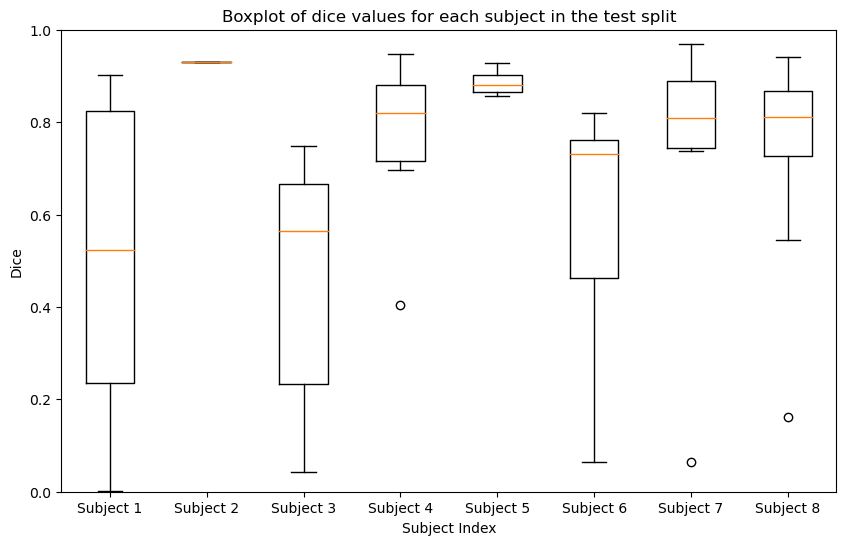

In [4]:
# Example data: a list of lists
data = Dice_for_subjects

# Create a figure and a set of subplots
plt.figure(figsize=(10, 6))

# Create the boxplot
plt.boxplot(data)

# Adding titles and labels
plt.title('Boxplot of dice values for each subject in the test split')
plt.xlabel('Subject Index')
plt.ylabel('Dice')

# Customize x-axis labels if needed
plt.xticks(range(1, len(data) + 1), ['Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8'])

# Set y-axis limits
plt.ylim(0, 1)

# Show the plot
plt.show()